In [ ]:
# =========================
# Colab: Prophet single-SKU trainer
# Example file: series_jumbo_storage_bag_suki.csv  (columns: DS, Y)
# =========================

# 1) Install deps (run once per runtime)
!pip -q install prophet

In [ ]:
# (Optional fallback if Prophet complains about CmdStan)
# import cmdstanpy
# cmdstanpy.install_cmdstan()  # may take several minutes  # docs: mc-stan.org/cmdstanpy/installation.html

# 2) Imports & setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_domsbzy/e_crkr2f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_domsbzy/oih9ny_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69045', 'data', 'file=/tmp/tmp_domsbzy/e_crkr2f.json', 'init=/tmp/tmp_domsbzy/oih9ny_s.json', 'output', 'file=/tmp/tmp_domsbzy/prophet_modeloj_35uig/prophet_model-20250915201027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:10:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:10:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Saving series_woodland_charlotte_bag_shifted.csv to series_woodland_charlotte_bag_shifted.csv
Train points: 245, Test points: 30
Holdout metrics (30 pts) -> MAE=0.6495 | MAPE=27.05% | RMSE=0.8612


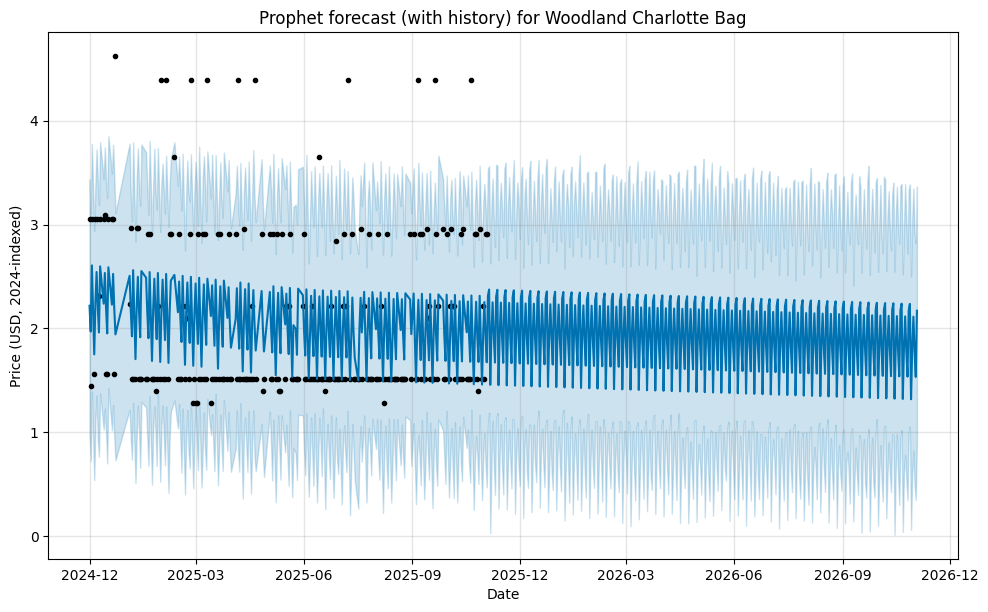

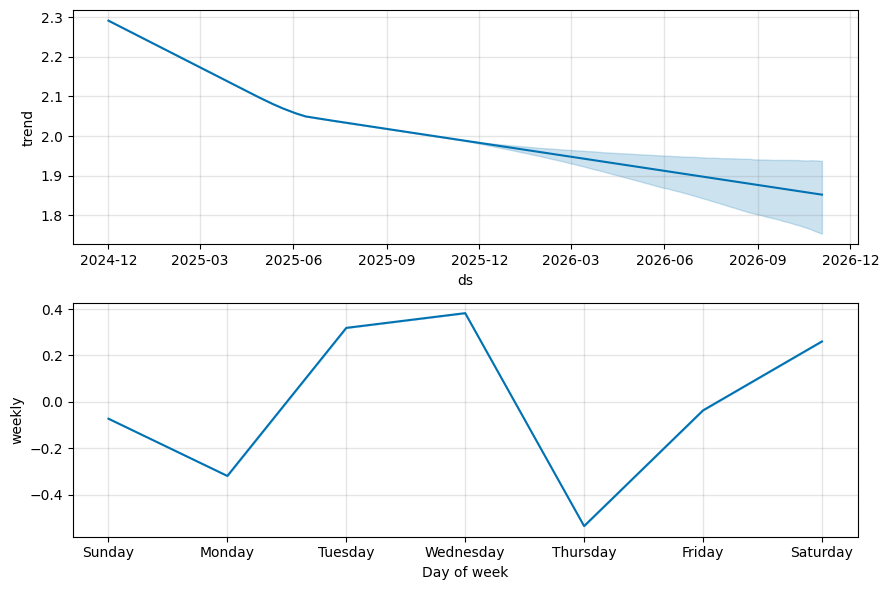

In [ ]:
# 3) Upload or set path
#   Option A: upload local CSV (choose your file: e.g. series_jumbo_storage_bag_suki.csv)
from google.colab import files
uploaded = files.upload()  # pick your per-SKU CSV

#   If you prefer a fixed name, set it here after upload:
csv_path = list(uploaded.keys())[0]  # e.g. 'series_jumbo_storage_bag_suki.csv'

# 4) Load data (expects columns DS, Y)
df = pd.read_csv(csv_path)

# basic checks
assert {'DS','Y'}.issubset(df.columns), "CSV must have columns: DS, Y"
df['DS'] = pd.to_datetime(df['DS'], errors='coerce')
df = df.dropna(subset=['DS','Y']).sort_values('DS').reset_index(drop=True)

# Prophet requires columns named 'ds' and 'y'
data = df.rename(columns={'DS':'ds','Y':'y'})

# 5) Train/Validation split (last N days = holdout)
holdout_days = 30  # you can change to 14/60/etc.
train = data.iloc[:-holdout_days].copy() if len(data) > holdout_days else data.copy()
test  = data.iloc[-holdout_days:].copy()  if len(data) > holdout_days else pd.DataFrame(columns=data.columns)

print(f"Train points: {len(train)}, Test points: {len(test)}")

# 6) Fit Prophet
m = Prophet(
    weekly_seasonality=True,   # useful for retail; yearly may be weak if ~1 year of history
    yearly_seasonality=False,  # set True if bạn có >2 năm dữ liệu
    changepoint_prior_scale=0.05,  # trend flexibility; tune if needed
    interval_width=0.9
)
m.fit(train)   # Prophet expects df with columns ds, y

# 7) Forecast on history + horizon
#    - To evaluate on holdout, forecast through the end of the dataset
#    - Also extend +365 days into the future for a 1-year projection
horizon_days = 365
future = m.make_future_dataframe(periods=horizon_days, freq='D', include_history=True)
fcst  = m.predict(future)

# 8) Evaluate on holdout (only where we have actuals)
if len(test) > 0:
    eval_df = test.merge(fcst[['ds','yhat','yhat_lower','yhat_upper']], on='ds', how='left')
    eval_df = eval_df.dropna(subset=['yhat']).copy()
    mae  = np.mean(np.abs(eval_df['y'] - eval_df['yhat']))
    mape = np.mean(np.abs((eval_df['y'] - eval_df['yhat']) / np.maximum(1e-9, eval_df['y']))) * 100
    rmse = np.sqrt(np.mean((eval_df['y'] - eval_df['yhat'])**2))
    print(f"Holdout metrics ({len(eval_df)} pts) -> MAE={mae:.4f} | MAPE={mape:.2f}% | RMSE={rmse:.4f}")

# 9) Plots
fig1 = m.plot(fcst)
plt.title("Prophet forecast (with history) for Woodland Charlotte Bag")
plt.xlabel("Date"); plt.ylabel("Price (USD, 2024-indexed)")
plt.show()

fig2 = m.plot_components(fcst)
plt.show()


In [ ]:
# 10) Save artifacts
# full forecast
fcst_out = fcst[['ds','yhat','yhat_lower','yhat_upper']].copy()
fcst_out.to_csv('prophet_forecast_Woodland Charlotte Bag.csv', index=False)

# predictions aligned to actuals (for the available period)
aligned = data.merge(fcst_out, on='ds', how='left')
aligned.to_csv('Woodland Charlotte Bag_with_actuals.csv', index=False)

print("Saved!")

Saved!
